In [15]:
!pip install keras
!pip install tensorflow
!pip install np_utils

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import print_function, division
from keras.layers import Conv1D, Input, Add, Activation, Dropout
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.initializers import TruncatedNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras import optimizers
from keras import backend as K
K.set_image_dim_ordering('tf')

In [17]:
def DC_CNN_Block(nb_filter, filter_length, dilation, l2_layer_reg):
    def f(input_):
        print(nb_filter, filter_length, dilation, l2_layer_reg) 
        residual =    input_
        
        layer_out =   Conv1D(filters=nb_filter, kernel_size=filter_length, 
                      dilation_rate=dilation, 
                      activation='linear', padding='causal', use_bias=False,
                      kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, 
                      seed=42), kernel_regularizer=l2(l2_layer_reg))(input_)
                    
        layer_out =   Activation('selu')(layer_out)
        
        skip_out =    Conv1D(1,1, activation='linear', use_bias=False, 
                      kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, 
                      seed=42), kernel_regularizer=l2(l2_layer_reg))(layer_out)
        
        network_in =  Conv1D(1,1, activation='linear', use_bias=False, 
                      kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, 
                      seed=42), kernel_regularizer=l2(l2_layer_reg))(layer_out)
                      
        network_out = Add()([residual, network_in])
        
        return network_out, skip_out
    
    return f


def DC_CNN_Model(length):
    
    input = Input(shape=(length,1))
    
    l1a, l1b = DC_CNN_Block(32,2,1,0.001)(input)    
    l2a, l2b = DC_CNN_Block(32,2,2,0.001)(l1a) 
    l3a, l3b = DC_CNN_Block(32,2,4,0.001)(l2a)
    l4a, l4b = DC_CNN_Block(32,2,8,0.001)(l3a)
    l5a, l5b = DC_CNN_Block(32,2,16,0.001)(l4a)
    l6a, l6b = DC_CNN_Block(32,2,32,0.001)(l5a)
    l6b = Dropout(0.8   )(l6b) #dropout used to limit influence of earlier data
    l7a, l7b = DC_CNN_Block(32,2,64,0.001)(l6a)
    l7b = Dropout(0.8)(l7b) #dropout used to limit influence of earlier data

    l8 =   Add()([l1b, l2b, l3b, l4b, l5b, l6b, l7b])
    
    l9 =   Activation('relu')(l8)
           
    l21 =  Conv1D(1,1, activation='linear', use_bias=False, 
           kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42),
           kernel_regularizer=l2(0.001))(l9)

    model = Model(input=input, output=l21)
    
    adam = optimizers.Adam(lr=0.00075, beta_1=0.9, beta_2=0.999, epsilon=None, 
                           decay=0.0, amsgrad=False)
   
    model.compile(loss='mae', optimizer=adam, metrics=['mse'])
    
    return model


def evaluate_timeseries(timeseries, predict_size):
    # timeseries input is 1-D numpy array
    # forecast_size is the forecast horizon
    
    timeseries = timeseries[~pd.isna(timeseries)]

    length = len(timeseries)-1

    timeseries = np.atleast_2d(np.asarray(timeseries))
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T 

    model = DC_CNN_Model(length)
    print('\n\nModel with input size {}, output size {}'.
                                format(model.input_shape, model.output_shape))
    
    model.summary()

    X = timeseries[:-1].reshape(1,length,1)
    y = timeseries[1:].reshape(1,length,1)
    
    model.fit(X, y, epochs=3000)
    
    pred_array = np.zeros(predict_size).reshape(1,predict_size,1)
    X_test_initial = timeseries[1:].reshape(1,length,1)
    #pred_array = model.predict(X_test_initial) if predictions of training samples required
    
    #forecast is created by predicting next future value based on previous predictions
    pred_array[:,0,:] = model.predict(X_test_initial)[:,-1:,:]
    for i in range(predict_size-1):
        pred_array[:,i+1:,:] = model.predict(np.append(X_test_initial[:,i+1:,:], 
                               pred_array[:,:i+1,:]).reshape(1,length,1))[:,-1:,:]
    
    return pred_array.flatten()
                           
                           
                                                             
                                                
                                            
                        

In [18]:
import pandas
test_range=11 # NUMBER OF PERIOD TO TEST FOR
data=pandas.read_csv('gdp.csv', sep=',')
new_data=[]
for i in range(data.shape[0]):
        new_data.append(data.values[i][1])
print(len(new_data))
pd_data = pd.DataFrame(new_data)
#data.values
predicted=evaluate_timeseries(pd_data[:-test_range-1],test_range)
print(predicted)


230
32 2 1 0.001
32 2 2 0.001
32 2 4 0.001
32 2 8 0.001
32 2 16 0.001
32 2 32 0.001
32 2 64 0.001


Model with input size (None, 217, 1), output size (None, 217, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 217, 1)       0                                            
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 217, 32)      64          input_3[0][0]                    
__________________________________________________________________________________________________
activation_17 (Activation)      (None, 217, 32)      0           conv1d_45[0][0]                  
__________________________________________________________________________________________________
conv1d_47 (Conv1D)              (None, 217,

/home/ubuntu/cerebri-ai/time_series/env/lib/python2.7/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


conv1d_56 (Conv1D)              (None, 217, 1)       32          activation_20[0][0]              
__________________________________________________________________________________________________
add_20 (Add)                    (None, 217, 1)       0           add_19[0][0]                     
                                                                 conv1d_56[0][0]                  
__________________________________________________________________________________________________
conv1d_57 (Conv1D)              (None, 217, 32)      64          add_20[0][0]                     
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 217, 32)      0           conv1d_57[0][0]                  
__________________________________________________________________________________________________
conv1d_59 (Conv1D)              (None, 217, 1)       32          activation_21[0][0]              
__________

Epoch 23/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.9484 - mean_squared_error: 1.3501
Epoch 24/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.9484 - mean_squared_error: 1.3501
Epoch 25/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.9484 - mean_squared_error: 1.3500
Epoch 26/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.9483 - mean_squared_error: 1.3500
Epoch 27/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.9483 - mean_squared_error: 1.3499
Epoch 28/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.9482 - mean_squared_error: 1.3499
Epoch 29/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.9482 - mean_squared_error: 1.3499
Epoch 30/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.9482 - mean_squared_error: 1.3498
Epoch 31/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.9482 - mean_squared_error: 1.3498
Epoch 32/3000
1/1 [

Epoch 99/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.7992 - mean_squared_error: 1.0279
Epoch 100/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.7923 - mean_squared_error: 1.0232
Epoch 101/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.7908 - mean_squared_error: 0.9875
Epoch 102/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.7883 - mean_squared_error: 0.9890
Epoch 103/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.7636 - mean_squared_error: 0.9568
Epoch 104/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.7287 - mean_squared_error: 0.8647
Epoch 105/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.7272 - mean_squared_error: 0.8663
Epoch 106/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.7507 - mean_squared_error: 0.9114
Epoch 107/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.7248 - mean_squared_error: 0.8500
Epoch 108/3

Epoch 174/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.6251 - mean_squared_error: 0.6531
Epoch 175/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.6214 - mean_squared_error: 0.6447
Epoch 176/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.6240 - mean_squared_error: 0.6508
Epoch 177/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.6213 - mean_squared_error: 0.6443
Epoch 178/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.6199 - mean_squared_error: 0.6435
Epoch 179/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.6213 - mean_squared_error: 0.6423
Epoch 180/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.6237 - mean_squared_error: 0.6526
Epoch 181/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.6232 - mean_squared_error: 0.6490
Epoch 182/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.6256 - mean_squared_error: 0.6563
Epoch 183/

Epoch 249/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.6086 - mean_squared_error: 0.6356
Epoch 250/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.6130 - mean_squared_error: 0.6388
Epoch 251/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.6111 - mean_squared_error: 0.6383
Epoch 252/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.6111 - mean_squared_error: 0.6353
Epoch 253/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.6098 - mean_squared_error: 0.6331
Epoch 254/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.6087 - mean_squared_error: 0.6334
Epoch 255/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.6068 - mean_squared_error: 0.6350
Epoch 256/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.6116 - mean_squared_error: 0.6365
Epoch 257/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.6126 - mean_squared_error: 0.6420
Epoch 258/

Epoch 324/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.6076 - mean_squared_error: 0.6341
Epoch 325/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.6044 - mean_squared_error: 0.6289
Epoch 326/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.6018 - mean_squared_error: 0.6281
Epoch 327/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.6073 - mean_squared_error: 0.6341
Epoch 328/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.6049 - mean_squared_error: 0.6334
Epoch 329/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.6061 - mean_squared_error: 0.6343
Epoch 330/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.6080 - mean_squared_error: 0.6378
Epoch 331/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.6055 - mean_squared_error: 0.6351
Epoch 332/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.6029 - mean_squared_error: 0.6280
Epoch 333/

Epoch 399/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5982 - mean_squared_error: 0.6248
Epoch 400/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.6000 - mean_squared_error: 0.6315
Epoch 401/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.6000 - mean_squared_error: 0.6339
Epoch 402/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5938 - mean_squared_error: 0.6213
Epoch 403/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.6019 - mean_squared_error: 0.6291
Epoch 404/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5969 - mean_squared_error: 0.6207
Epoch 405/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5938 - mean_squared_error: 0.6242
Epoch 406/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.6004 - mean_squared_error: 0.6256
Epoch 407/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.6058 - mean_squared_error: 0.6363
Epoch 408/

Epoch 474/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5954 - mean_squared_error: 0.6248
Epoch 475/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5944 - mean_squared_error: 0.6284
Epoch 476/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5960 - mean_squared_error: 0.6221
Epoch 477/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5964 - mean_squared_error: 0.6294
Epoch 478/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5927 - mean_squared_error: 0.6236
Epoch 479/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5931 - mean_squared_error: 0.6183
Epoch 480/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5983 - mean_squared_error: 0.6285
Epoch 481/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5937 - mean_squared_error: 0.6267
Epoch 482/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5826 - mean_squared_error: 0.6085
Epoch 483/

Epoch 549/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5762 - mean_squared_error: 0.6083
Epoch 550/3000
1/1 [==============================] - 0s 10ms/step - loss: 0.5817 - mean_squared_error: 0.6147
Epoch 551/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5848 - mean_squared_error: 0.6126
Epoch 552/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5846 - mean_squared_error: 0.6146
Epoch 553/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.5874 - mean_squared_error: 0.6155
Epoch 554/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5826 - mean_squared_error: 0.6122
Epoch 555/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5859 - mean_squared_error: 0.6244
Epoch 556/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5843 - mean_squared_error: 0.6126
Epoch 557/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5908 - mean_squared_error: 0.6259
Epoch 558

Epoch 624/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5860 - mean_squared_error: 0.6285
Epoch 625/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5890 - mean_squared_error: 0.6294
Epoch 626/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5817 - mean_squared_error: 0.6142
Epoch 627/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5888 - mean_squared_error: 0.6278
Epoch 628/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5868 - mean_squared_error: 0.6240
Epoch 629/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5768 - mean_squared_error: 0.6052
Epoch 630/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5771 - mean_squared_error: 0.6151
Epoch 631/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.5849 - mean_squared_error: 0.6250
Epoch 632/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5826 - mean_squared_error: 0.6247
Epoch 633/

Epoch 699/3000
1/1 [==============================] - 0s 10ms/step - loss: 0.5896 - mean_squared_error: 0.6280
Epoch 700/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5879 - mean_squared_error: 0.6285
Epoch 701/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.5886 - mean_squared_error: 0.6362
Epoch 702/3000
1/1 [==============================] - 0s 12ms/step - loss: 0.5838 - mean_squared_error: 0.6244
Epoch 703/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5839 - mean_squared_error: 0.6354
Epoch 704/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5833 - mean_squared_error: 0.6245
Epoch 705/3000
1/1 [==============================] - 0s 10ms/step - loss: 0.5789 - mean_squared_error: 0.6164
Epoch 706/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5854 - mean_squared_error: 0.6236
Epoch 707/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5823 - mean_squared_error: 0.6260
Epoch 7

Epoch 774/3000
1/1 [==============================] - 0s 10ms/step - loss: 0.5752 - mean_squared_error: 0.6153
Epoch 775/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5865 - mean_squared_error: 0.6228
Epoch 776/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5867 - mean_squared_error: 0.6191
Epoch 777/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.5793 - mean_squared_error: 0.6160
Epoch 778/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.5784 - mean_squared_error: 0.6213
Epoch 779/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5849 - mean_squared_error: 0.6210
Epoch 780/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5801 - mean_squared_error: 0.6262
Epoch 781/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5783 - mean_squared_error: 0.6202
Epoch 782/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5831 - mean_squared_error: 0.6288
Epoch 783

Epoch 849/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5803 - mean_squared_error: 0.6173
Epoch 850/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5832 - mean_squared_error: 0.6217
Epoch 851/3000
1/1 [==============================] - 0s 10ms/step - loss: 0.5745 - mean_squared_error: 0.6150
Epoch 852/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5791 - mean_squared_error: 0.6247
Epoch 853/3000
1/1 [==============================] - 0s 10ms/step - loss: 0.5829 - mean_squared_error: 0.6307
Epoch 854/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5752 - mean_squared_error: 0.6118
Epoch 855/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5855 - mean_squared_error: 0.6282
Epoch 856/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5730 - mean_squared_error: 0.6158
Epoch 857/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5804 - mean_squared_error: 0.6264
Epoch 85

Epoch 924/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.5739 - mean_squared_error: 0.6096
Epoch 925/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5851 - mean_squared_error: 0.6252
Epoch 926/3000
1/1 [==============================] - 0s 10ms/step - loss: 0.5707 - mean_squared_error: 0.6101
Epoch 927/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.5734 - mean_squared_error: 0.6143
Epoch 928/3000
1/1 [==============================] - 0s 11ms/step - loss: 0.5775 - mean_squared_error: 0.6168
Epoch 929/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5729 - mean_squared_error: 0.6082
Epoch 930/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5769 - mean_squared_error: 0.6144
Epoch 931/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5714 - mean_squared_error: 0.6046
Epoch 932/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5805 - mean_squared_error: 0.6206
Epoch 93

Epoch 999/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5789 - mean_squared_error: 0.6147
Epoch 1000/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5749 - mean_squared_error: 0.6183
Epoch 1001/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5802 - mean_squared_error: 0.6150
Epoch 1002/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5775 - mean_squared_error: 0.6193
Epoch 1003/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5743 - mean_squared_error: 0.6161
Epoch 1004/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5751 - mean_squared_error: 0.6192
Epoch 1005/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5715 - mean_squared_error: 0.5959
Epoch 1006/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5766 - mean_squared_error: 0.6163
Epoch 1007/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5755 - mean_squared_error: 0.6113
Ep

Epoch 1073/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5716 - mean_squared_error: 0.6026
Epoch 1074/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5754 - mean_squared_error: 0.6042
Epoch 1075/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5716 - mean_squared_error: 0.6088
Epoch 1076/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.5699 - mean_squared_error: 0.6032
Epoch 1077/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5768 - mean_squared_error: 0.6121
Epoch 1078/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5674 - mean_squared_error: 0.5997
Epoch 1079/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5648 - mean_squared_error: 0.5934
Epoch 1080/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5769 - mean_squared_error: 0.6184
Epoch 1081/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5722 - mean_squared_error: 0.6039
E

Epoch 1147/3000
1/1 [==============================] - 0s 11ms/step - loss: 0.5747 - mean_squared_error: 0.6047
Epoch 1148/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5724 - mean_squared_error: 0.6033
Epoch 1149/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.5693 - mean_squared_error: 0.6015
Epoch 1150/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5763 - mean_squared_error: 0.6096
Epoch 1151/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.5730 - mean_squared_error: 0.6063
Epoch 1152/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5780 - mean_squared_error: 0.6085
Epoch 1153/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5754 - mean_squared_error: 0.6043
Epoch 1154/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5680 - mean_squared_error: 0.5952
Epoch 1155/3000
1/1 [==============================] - 0s 11ms/step - loss: 0.5818 - mean_squared_error: 0.6195

Epoch 1221/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5771 - mean_squared_error: 0.6035
Epoch 1222/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5780 - mean_squared_error: 0.6158
Epoch 1223/3000
1/1 [==============================] - 0s 12ms/step - loss: 0.5703 - mean_squared_error: 0.5883
Epoch 1224/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5693 - mean_squared_error: 0.6065
Epoch 1225/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5669 - mean_squared_error: 0.5972
Epoch 1226/3000
1/1 [==============================] - 0s 11ms/step - loss: 0.5737 - mean_squared_error: 0.6075
Epoch 1227/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5695 - mean_squared_error: 0.5996
Epoch 1228/3000
1/1 [==============================] - 0s 13ms/step - loss: 0.5769 - mean_squared_error: 0.6001
Epoch 1229/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5689 - mean_squared_error: 0.601

Epoch 1295/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5642 - mean_squared_error: 0.5837
Epoch 1296/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5611 - mean_squared_error: 0.5785
Epoch 1297/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5772 - mean_squared_error: 0.6107
Epoch 1298/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5765 - mean_squared_error: 0.6084
Epoch 1299/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5715 - mean_squared_error: 0.5975
Epoch 1300/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5716 - mean_squared_error: 0.5989
Epoch 1301/3000
1/1 [==============================] - 0s 10ms/step - loss: 0.5700 - mean_squared_error: 0.5915
Epoch 1302/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5704 - mean_squared_error: 0.5997
Epoch 1303/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5772 - mean_squared_error: 0.6093


Epoch 1369/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5698 - mean_squared_error: 0.5867
Epoch 1370/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5788 - mean_squared_error: 0.6072
Epoch 1371/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5772 - mean_squared_error: 0.6029
Epoch 1372/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5728 - mean_squared_error: 0.6068
Epoch 1373/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5701 - mean_squared_error: 0.5958
Epoch 1374/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5711 - mean_squared_error: 0.6023
Epoch 1375/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5671 - mean_squared_error: 0.5937
Epoch 1376/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5767 - mean_squared_error: 0.6049
Epoch 1377/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5720 - mean_squared_error: 0.6027
E

Epoch 1443/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5708 - mean_squared_error: 0.6014
Epoch 1444/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5740 - mean_squared_error: 0.6004
Epoch 1445/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5682 - mean_squared_error: 0.5973
Epoch 1446/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5722 - mean_squared_error: 0.6007
Epoch 1447/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5672 - mean_squared_error: 0.5862
Epoch 1448/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5744 - mean_squared_error: 0.6040
Epoch 1449/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5732 - mean_squared_error: 0.6019
Epoch 1450/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5735 - mean_squared_error: 0.5992
Epoch 1451/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.5710 - mean_squared_error: 0.5874
E

Epoch 1517/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5725 - mean_squared_error: 0.6006
Epoch 1518/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5734 - mean_squared_error: 0.6011
Epoch 1519/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5595 - mean_squared_error: 0.5825
Epoch 1520/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5798 - mean_squared_error: 0.6133
Epoch 1521/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5681 - mean_squared_error: 0.5901
Epoch 1522/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5723 - mean_squared_error: 0.5967
Epoch 1523/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5683 - mean_squared_error: 0.5879
Epoch 1524/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5594 - mean_squared_error: 0.5812
Epoch 1525/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5698 - mean_squared_error: 0.5990
E

Epoch 1591/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5694 - mean_squared_error: 0.5819
Epoch 1592/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5725 - mean_squared_error: 0.5942
Epoch 1593/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5715 - mean_squared_error: 0.5910
Epoch 1594/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5602 - mean_squared_error: 0.5738
Epoch 1595/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5650 - mean_squared_error: 0.5939
Epoch 1596/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5714 - mean_squared_error: 0.5954
Epoch 1597/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5729 - mean_squared_error: 0.5970
Epoch 1598/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5718 - mean_squared_error: 0.5894
Epoch 1599/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.5694 - mean_squared_error: 0.5892
E

Epoch 1665/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5763 - mean_squared_error: 0.5992
Epoch 1666/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5683 - mean_squared_error: 0.5909
Epoch 1667/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5653 - mean_squared_error: 0.5938
Epoch 1668/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5699 - mean_squared_error: 0.5932
Epoch 1669/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5732 - mean_squared_error: 0.5940
Epoch 1670/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5577 - mean_squared_error: 0.5814
Epoch 1671/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5646 - mean_squared_error: 0.5865
Epoch 1672/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.5716 - mean_squared_error: 0.5936
Epoch 1673/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5648 - mean_squared_error: 0.5866
E

Epoch 1739/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5619 - mean_squared_error: 0.5845
Epoch 1740/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5703 - mean_squared_error: 0.5987
Epoch 1741/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5660 - mean_squared_error: 0.5900
Epoch 1742/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5708 - mean_squared_error: 0.5921
Epoch 1743/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5768 - mean_squared_error: 0.6013
Epoch 1744/3000
1/1 [==============================] - 0s 10ms/step - loss: 0.5668 - mean_squared_error: 0.5874
Epoch 1745/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5617 - mean_squared_error: 0.5799
Epoch 1746/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5679 - mean_squared_error: 0.5868
Epoch 1747/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5664 - mean_squared_error: 0.5760


Epoch 1813/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5577 - mean_squared_error: 0.5627
Epoch 1814/3000
1/1 [==============================] - 0s 12ms/step - loss: 0.5742 - mean_squared_error: 0.5976
Epoch 1815/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5573 - mean_squared_error: 0.5666
Epoch 1816/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5750 - mean_squared_error: 0.5915
Epoch 1817/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5766 - mean_squared_error: 0.6020
Epoch 1818/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5736 - mean_squared_error: 0.5935
Epoch 1819/3000
1/1 [==============================] - 0s 10ms/step - loss: 0.5724 - mean_squared_error: 0.5967
Epoch 1820/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5657 - mean_squared_error: 0.5732
Epoch 1821/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5679 - mean_squared_error: 0.5933

Epoch 1887/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5644 - mean_squared_error: 0.5783
Epoch 1888/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5653 - mean_squared_error: 0.5829
Epoch 1889/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5686 - mean_squared_error: 0.5916
Epoch 1890/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5675 - mean_squared_error: 0.5869
Epoch 1891/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5685 - mean_squared_error: 0.5886
Epoch 1892/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.5658 - mean_squared_error: 0.5812
Epoch 1893/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5661 - mean_squared_error: 0.5810
Epoch 1894/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5667 - mean_squared_error: 0.5827
Epoch 1895/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5683 - mean_squared_error: 0.5921
E

Epoch 1961/3000
1/1 [==============================] - 0s 11ms/step - loss: 0.5641 - mean_squared_error: 0.5746
Epoch 1962/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5670 - mean_squared_error: 0.5861
Epoch 1963/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5651 - mean_squared_error: 0.5841
Epoch 1964/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5676 - mean_squared_error: 0.5886
Epoch 1965/3000
1/1 [==============================] - 0s 11ms/step - loss: 0.5669 - mean_squared_error: 0.5896
Epoch 1966/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5637 - mean_squared_error: 0.5786
Epoch 1967/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.5662 - mean_squared_error: 0.5843
Epoch 1968/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5671 - mean_squared_error: 0.5861
Epoch 1969/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5676 - mean_squared_error: 0.5817

Epoch 2035/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5681 - mean_squared_error: 0.5843
Epoch 2036/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5696 - mean_squared_error: 0.5849
Epoch 2037/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5651 - mean_squared_error: 0.5782
Epoch 2038/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5629 - mean_squared_error: 0.5872
Epoch 2039/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5607 - mean_squared_error: 0.5738
Epoch 2040/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5716 - mean_squared_error: 0.5832
Epoch 2041/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5649 - mean_squared_error: 0.5879
Epoch 2042/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5619 - mean_squared_error: 0.5765
Epoch 2043/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5641 - mean_squared_error: 0.5797
E

Epoch 2109/3000
1/1 [==============================] - 0s 10ms/step - loss: 0.5709 - mean_squared_error: 0.5828
Epoch 2110/3000
1/1 [==============================] - 0s 10ms/step - loss: 0.5656 - mean_squared_error: 0.5776
Epoch 2111/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5636 - mean_squared_error: 0.5776
Epoch 2112/3000
1/1 [==============================] - 0s 10ms/step - loss: 0.5704 - mean_squared_error: 0.5761
Epoch 2113/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5724 - mean_squared_error: 0.5946
Epoch 2114/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5668 - mean_squared_error: 0.5800
Epoch 2115/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.5618 - mean_squared_error: 0.5719
Epoch 2116/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5596 - mean_squared_error: 0.5781
Epoch 2117/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5652 - mean_squared_error: 0.582

Epoch 2183/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5605 - mean_squared_error: 0.5814
Epoch 2184/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5643 - mean_squared_error: 0.5723
Epoch 2185/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5651 - mean_squared_error: 0.5876
Epoch 2186/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5636 - mean_squared_error: 0.5801
Epoch 2187/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5643 - mean_squared_error: 0.5763
Epoch 2188/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5620 - mean_squared_error: 0.5746
Epoch 2189/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5623 - mean_squared_error: 0.5771
Epoch 2190/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5648 - mean_squared_error: 0.5829
Epoch 2191/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5591 - mean_squared_error: 0.5774
E

Epoch 2257/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5633 - mean_squared_error: 0.5732
Epoch 2258/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5618 - mean_squared_error: 0.5751
Epoch 2259/3000
1/1 [==============================] - 0s 11ms/step - loss: 0.5660 - mean_squared_error: 0.5851
Epoch 2260/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5590 - mean_squared_error: 0.5690
Epoch 2261/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5672 - mean_squared_error: 0.5870
Epoch 2262/3000
1/1 [==============================] - 0s 11ms/step - loss: 0.5747 - mean_squared_error: 0.5881
Epoch 2263/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5624 - mean_squared_error: 0.5805
Epoch 2264/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5596 - mean_squared_error: 0.5731
Epoch 2265/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.5625 - mean_squared_error: 0.5737

Epoch 2331/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5609 - mean_squared_error: 0.5781
Epoch 2332/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.5629 - mean_squared_error: 0.5722
Epoch 2333/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5593 - mean_squared_error: 0.5724
Epoch 2334/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5610 - mean_squared_error: 0.5721
Epoch 2335/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5654 - mean_squared_error: 0.5794
Epoch 2336/3000
1/1 [==============================] - 0s 10ms/step - loss: 0.5635 - mean_squared_error: 0.5755
Epoch 2337/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5572 - mean_squared_error: 0.5652
Epoch 2338/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5668 - mean_squared_error: 0.5809
Epoch 2339/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5643 - mean_squared_error: 0.5839


Epoch 2405/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.5612 - mean_squared_error: 0.5716
Epoch 2406/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5632 - mean_squared_error: 0.5824
Epoch 2407/3000
1/1 [==============================] - 0s 10ms/step - loss: 0.5654 - mean_squared_error: 0.5781
Epoch 2408/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5614 - mean_squared_error: 0.5791
Epoch 2409/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5585 - mean_squared_error: 0.5708
Epoch 2410/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5642 - mean_squared_error: 0.5832
Epoch 2411/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5645 - mean_squared_error: 0.5783
Epoch 2412/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5587 - mean_squared_error: 0.5660
Epoch 2413/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5585 - mean_squared_error: 0.5746


Epoch 2479/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5536 - mean_squared_error: 0.5703
Epoch 2480/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5546 - mean_squared_error: 0.5682
Epoch 2481/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5568 - mean_squared_error: 0.5669
Epoch 2482/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5597 - mean_squared_error: 0.5755
Epoch 2483/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5586 - mean_squared_error: 0.5785
Epoch 2484/3000
1/1 [==============================] - 0s 12ms/step - loss: 0.5616 - mean_squared_error: 0.5751
Epoch 2485/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5639 - mean_squared_error: 0.5783
Epoch 2486/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5670 - mean_squared_error: 0.5799
Epoch 2487/3000
1/1 [==============================] - 0s 10ms/step - loss: 0.5631 - mean_squared_error: 0.5774

Epoch 2553/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5603 - mean_squared_error: 0.5715
Epoch 2554/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5566 - mean_squared_error: 0.5650
Epoch 2555/3000
1/1 [==============================] - 0s 10ms/step - loss: 0.5650 - mean_squared_error: 0.5712
Epoch 2556/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5619 - mean_squared_error: 0.5793
Epoch 2557/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5640 - mean_squared_error: 0.5761
Epoch 2558/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5587 - mean_squared_error: 0.5716
Epoch 2559/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5582 - mean_squared_error: 0.5704
Epoch 2560/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.5561 - mean_squared_error: 0.5743
Epoch 2561/3000
1/1 [==============================] - 0s 11ms/step - loss: 0.5645 - mean_squared_error: 0.5773

Epoch 2627/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5579 - mean_squared_error: 0.5691
Epoch 2628/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5537 - mean_squared_error: 0.5593
Epoch 2629/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5587 - mean_squared_error: 0.5680
Epoch 2630/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5625 - mean_squared_error: 0.5744
Epoch 2631/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5637 - mean_squared_error: 0.5789
Epoch 2632/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5624 - mean_squared_error: 0.5843
Epoch 2633/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5641 - mean_squared_error: 0.5775
Epoch 2634/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5614 - mean_squared_error: 0.5750
Epoch 2635/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5636 - mean_squared_error: 0.5781
E

Epoch 2701/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5591 - mean_squared_error: 0.5693
Epoch 2702/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5570 - mean_squared_error: 0.5690
Epoch 2703/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5597 - mean_squared_error: 0.5735
Epoch 2704/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5560 - mean_squared_error: 0.5671
Epoch 2705/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5580 - mean_squared_error: 0.5786
Epoch 2706/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5583 - mean_squared_error: 0.5760
Epoch 2707/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5523 - mean_squared_error: 0.5626
Epoch 2708/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5543 - mean_squared_error: 0.5654
Epoch 2709/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5627 - mean_squared_error: 0.5716
E

Epoch 2775/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5634 - mean_squared_error: 0.5766
Epoch 2776/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5549 - mean_squared_error: 0.5679
Epoch 2777/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5641 - mean_squared_error: 0.5740
Epoch 2778/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5607 - mean_squared_error: 0.5664
Epoch 2779/3000
1/1 [==============================] - 0s 14ms/step - loss: 0.5599 - mean_squared_error: 0.5724
Epoch 2780/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5607 - mean_squared_error: 0.5651
Epoch 2781/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.5590 - mean_squared_error: 0.5753
Epoch 2782/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5603 - mean_squared_error: 0.5732
Epoch 2783/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5564 - mean_squared_error: 0.5637


Epoch 2849/3000
1/1 [==============================] - 0s 10ms/step - loss: 0.5587 - mean_squared_error: 0.5657
Epoch 2850/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5553 - mean_squared_error: 0.5649
Epoch 2851/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5643 - mean_squared_error: 0.5734
Epoch 2852/3000
1/1 [==============================] - 0s 9ms/step - loss: 0.5564 - mean_squared_error: 0.5640
Epoch 2853/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5545 - mean_squared_error: 0.5617
Epoch 2854/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5549 - mean_squared_error: 0.5668
Epoch 2855/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5637 - mean_squared_error: 0.5711
Epoch 2856/3000
1/1 [==============================] - 0s 11ms/step - loss: 0.5659 - mean_squared_error: 0.5773
Epoch 2857/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5635 - mean_squared_error: 0.5752

Epoch 2923/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5547 - mean_squared_error: 0.5630
Epoch 2924/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5586 - mean_squared_error: 0.5628
Epoch 2925/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5580 - mean_squared_error: 0.5661
Epoch 2926/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5538 - mean_squared_error: 0.5639
Epoch 2927/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5537 - mean_squared_error: 0.5616
Epoch 2928/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5522 - mean_squared_error: 0.5625
Epoch 2929/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5593 - mean_squared_error: 0.5674
Epoch 2930/3000
1/1 [==============================] - 0s 7ms/step - loss: 0.5614 - mean_squared_error: 0.5736
Epoch 2931/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.5640 - mean_squared_error: 0.5756
E

Epoch 2997/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.5568 - mean_squared_error: 0.5525
Epoch 2998/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.5621 - mean_squared_error: 0.5675
Epoch 2999/3000
1/1 [==============================] - 0s 12ms/step - loss: 0.5550 - mean_squared_error: 0.5627
Epoch 3000/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.5573 - mean_squared_error: 0.5639
[0.4496479  1.21150351 1.12801743 0.93343276 1.28678107 0.74500984
 0.81823087 0.75001925 0.70091242 0.73804373 0.69333303]


In [19]:
pd_predicted=[]

# intialize with zeros
for i in range(230 - test_range -1):
    pd_predicted.append(0)
print(len(pd_predicted))
#  
for i in range(test_range):
    pd_predicted.append(predicted[i])
print(pd_predicted)
pd_predicted[-20:]

218
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4496479034423828, 1.211503505706787, 1.1280174255371094, 0.9334327578544617, 1.2867810726165771, 0.7450098395347595, 0.8182308673858643, 0.7500192523002625, 0.7009124159812927, 0.7380437254905701, 0.6933330297470093]


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.4496479034423828,
 1.211503505706787,
 1.1280174255371094,
 0.9334327578544617,
 1.2867810726165771,
 0.7450098395347595,
 0.8182308673858643,
 0.7500192523002625,
 0.7009124159812927,
 0.7380437254905701,
 0.6933330297470093]

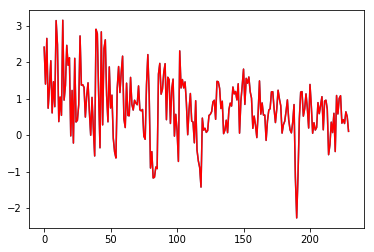

In [20]:
%matplotlib inline
from matplotlib.pyplot import plot
plot(pd_data)
plt.plot(pd_data,'r-')
#plt.plot(pd_predicted,"b-")

In [21]:
len(pd_predicted)

229

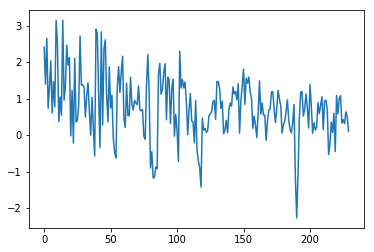

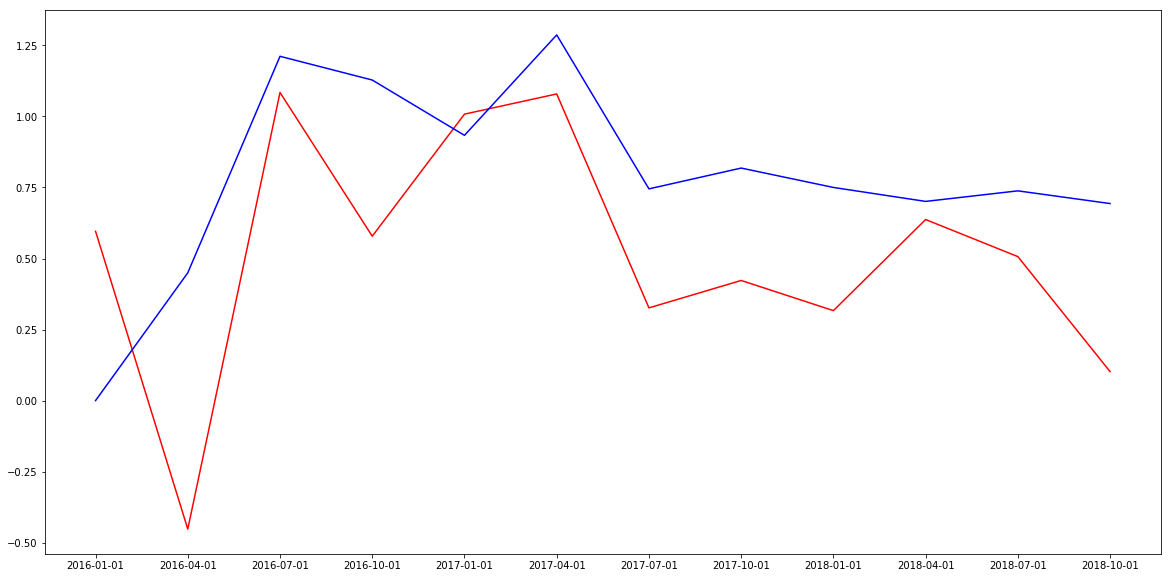

In [22]:
%matplotlib inline
from matplotlib.pyplot import plot
plot(pd_data)
plt.figure(figsize=(20,10))
plt.plot(data.values[:,0][-test_range-1:],pd_data.values[-test_range- 1:],'r-')
plt.plot(data.values[:,0][-test_range-1:],pd_predicted[-test_range -1 :],"b-")
plt.show()